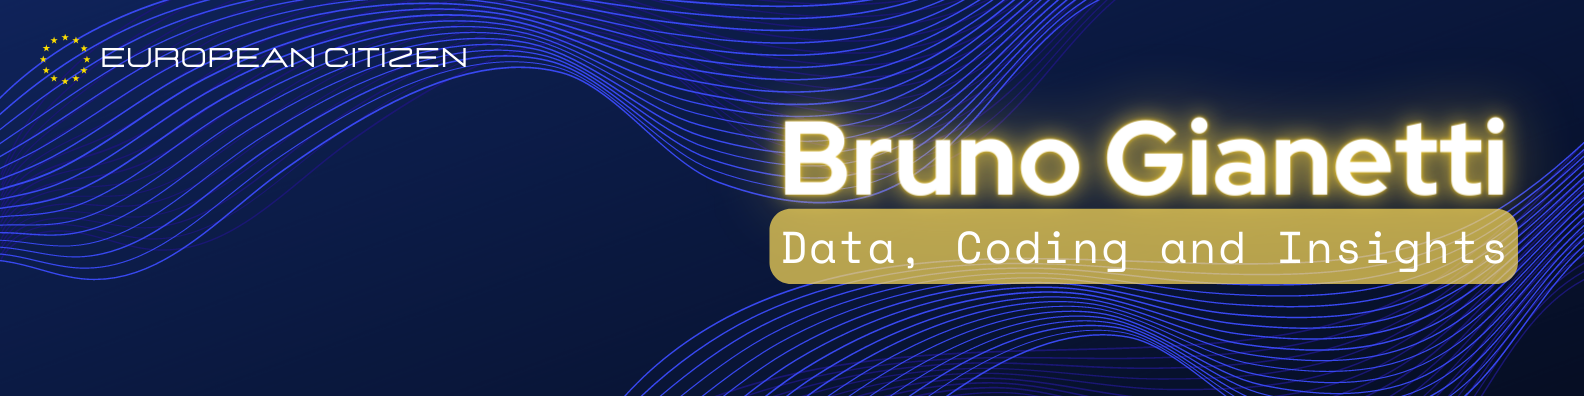

---
# BACKTESTING USING BT LIBRARY WITH PYTHON
---

## Instalando e importando bibliotecas

In [128]:
!pip install bt

In [129]:
!pip install yfinance

In [130]:
import bt
import yfinance as yf
import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
%matplotlib inline

## Acessando a base de dados do Banco Central

In [131]:
def consulta_bc(codigo_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

## Calculando o CDI acumulado

In [132]:
def cdi_acumulado(data_inicio, data_fim):
    cdi = consulta_bc(12)
    cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
    cdi_acumulado.iloc[0] = 1
    return cdi_acumulado

## Obtendo e Tratando os dados

In [133]:
data_inicio = '2018-01-02'
data_fim = '2023-01-28'

In [134]:
cdi = cdi_acumulado(data_inicio, data_fim)
cdi.index[0]

Timestamp('2018-01-02 00:00:00')

In [135]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [136]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim, ignore_tz = True)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [137]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [138]:
carteira

,BOVA11.SA,SMAL11.SA,renda_fixa
Date,,,
2018-01-02,75.099998,81.500000,1.000000
2018-01-03,75.300003,81.650002,1.000529
2018-01-04,76.000000,81.750000,1.000794
2018-01-05,76.440002,81.900002,1.001058
2018-01-08,76.760002,81.900002,1.001323
...,...,...,...
2023-01-20,108.449997,97.550003,1.370323
2023-01-23,107.900002,96.449997,1.371019
2023-01-24,109.430000,98.260002,1.371715


## Backtesting

In [139]:
rebalanceamento = bt.Strategy('rebalanceamento', [
    bt.algos.RunMonthly(run_on_end_of_period=True),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

In [140]:
buy_hold = bt.Strategy('Buy&Hold',[
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

In [141]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11.SA', 'SMAL11.SA']])

In [142]:
resultados = bt.run(bt1, bt2)

## Resultados

In [143]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2018-01-01         2018-01-01
End                  2023-01-26         2023-01-26
Risk-free rate       0.00%              0.00%

Total Return         42.16%             34.46%
Daily Sharpe         0.48               0.35
Daily Sortino        0.71               0.52
CAGR                 7.19%              6.02%
Max Drawdown         -33.86%            -49.15%
Calmar Ratio         0.21               0.12

MTD                  2.72%              3.63%
3m                   0.08%              -1.52%
6m                   10.39%             12.02%
YTD                  2.72%              3.63%
1Y                   1.56%              -4.43%
3Y (ann.)            -0.24%             -5.56%
5Y (ann.)            6.27%              4.65%
10Y (ann.)           -                  -
Since Incep. (ann.)  7.19%              6.02%

Daily Sharpe         0.48               0.35
Daily Sortino 

<AxesSubplot:title={'center':'Equity Progression'}>

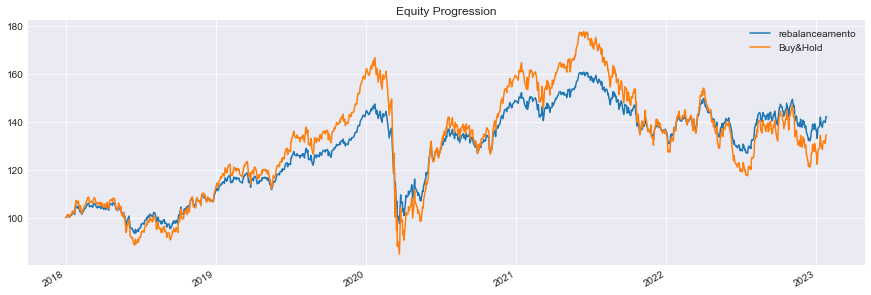

In [144]:
resultados.plot()

## Operações

In [145]:
resultados.get_transactions()

price  quantity
Date       Security                        
2018-01-02 BOVA11.SA    75.099998    4438.0
           SMAL11.SA    81.500000    4089.0
           renda_fixa    1.000000  333333.0
2018-01-31 BOVA11.SA    82.000000    -196.0
           SMAL11.SA    84.199997      42.0
...                           ...       ...
2022-11-30 SMAL11.SA    99.980003     329.0
           renda_fixa    1.344819  -19883.0
2022-12-29 BOVA11.SA   105.949997      37.0
           SMAL11.SA    96.519997      90.0
           renda_fixa    1.359236   -9228.0

[180 rows x 2 columns]

## Pesos

In [146]:
resultados.get_security_weights()

,BOVA11.SA,SMAL11.SA,renda_fixa
2018-01-01,0.000000,0.000000,0.000000
2018-01-02,0.333294,0.333253,0.333333
2018-01-03,0.333622,0.333308,0.332951
2018-01-04,0.335516,0.332520,0.331845
2018-01-05,0.336570,0.332253,0.331059
...,...,...,...
2023-01-20,0.336429,0.332154,0.331366
2023-01-23,0.336501,0.330153,0.333295
2023-01-24,0.337514,0.332644,0.329792
2023-01-25,0.338866,0.333455,0.327629


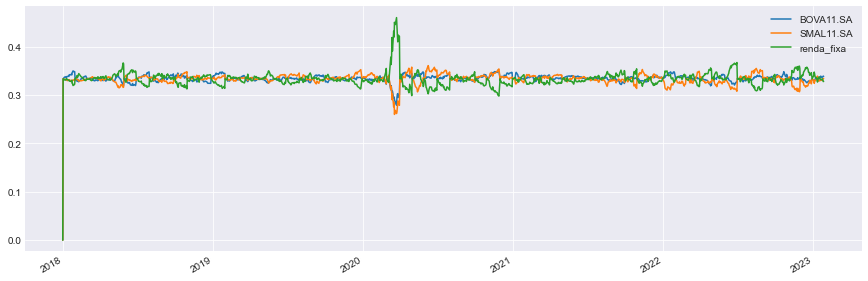

In [147]:
resultados.plot_security_weights()